Main Question 1:


* How effective are deep learning models (FNN, GRU, RNN) in predicting employee turnover?

Sub-questions:

* Which deep learning models are the most effective?
* How will these models be evaluated for accuracy?

# Set Up

In [ ]:
!pip install tensorflow keras
!pip install optuna-integration[tfkeras]


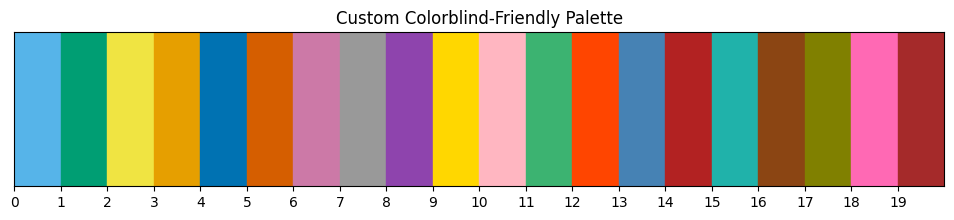

In [ ]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler

# Deep Learning Libraries (TensorFlow and Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, Embedding, Dropout, Masking, Input
from tensorflow.keras.optimizers import Adam, RMSprop

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Utilities
from collections import Counter

# Preprocessing and Metrics (Scikit-learn)
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    classification_report,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc
)

# Utilities
from tqdm import tqdm  # Progress bar for long iterations
from datetime import timedelta  # Time delta calculations

# Configure default plot size for matplotlib
plt.rcParams['figure.figsize'] = (10, 6)

# Define a colorblind-friendly palette
color_palette = [
    "#56B4E9",  # sky blue
    "#009E73",  # green
    "#F0E442",  # yellow
    "#E69F00",  # orange
    "#0072B2",  # blue
    "#D55E00",  # red-orange
    "#CC79A7",  # pink
    "#999999",  # grey
    "#8E44AD",  # purple
    "#FFD700",  # gold
    "#FFB6C1",  # light pink
    "#3CB371",  # medium sea green
    "#FF4500",  # orange-red
    "#4682B4",  # steel blue
    "#B22222",  # firebrick
    "#20B2AA",  # light sea green
    "#8B4513",  # saddle brown
    "#808000",  # olive
    "#FF69B4",  # hot pink
    "#A52A2A",  # brown
]

# Apply the color palette to matplotlib's axes property cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=color_palette)

# Visualize the custom colorblind-friendly palette
fig, ax = plt.subplots(figsize=(12, 2))
for i, color in enumerate(color_palette):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
ax.set_xlim(0, len(color_palette))
ax.set_yticks([])
ax.set_xticks(range(len(color_palette)))
plt.title("Custom Colorblind-Friendly Palette")
plt.show()


In [ ]:
# Check the status of the NVIDIA GPU
!nvidia-smi

Mon Jan 13 22:31:10 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              40W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Datasets

In [ ]:
# Read the CSV file
users = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/TT/DATA/user_cleaned.csv',
    parse_dates=[
        'first_login', 'last_login', 'updated', 'used', 'suspended_at', 'created'  # Columns to parse as datetime
    ],
    dtype={
        'suspended': 'bool',                 # Boolean column
        'stream_id': 'object',              # Float column for IDs or numeric values
        'userid': 'object',                  # User ID as string
        'org_unit_id': 'object',             # Organizational unit ID as string
        'position': 'object',                # Position as string
        'country': 'object',                 # Country as string
        'total_of_departments': 'int64',     # Integer column for department counts
        'total_of_jobs': 'int64'             # Integer column for job counts
    }
)

# Display DataFrame information to confirm correct parsing
users.info()
users.iloc[:]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151632 entries, 0 to 151631
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   first_login             63468 non-null   datetime64[ns]
 1   suspended               151632 non-null  bool          
 2   stream_id               151632 non-null  object        
 3   userid                  151632 non-null  object        
 4   org_unit_id             151632 non-null  object        
 5   last_login              63468 non-null   datetime64[ns]
 6   updated                 151632 non-null  datetime64[ns]
 7   used                    63464 non-null   datetime64[ns]
 8   display_name_extension  151632 non-null  object        
 9   suspended_at            76809 non-null   datetime64[ns]
 10  created                 151632 non-null  datetime64[ns]
 11  position                151632 non-null  object        
 12  country                 151632

,first_login,suspended,stream_id,userid,org_unit_id,last_login,updated,used,display_name_extension,suspended_at,created,position,country,total_of_departments,total_of_jobs,days_active
0,2023-12-09 22:35:18,False,234988.0,3ec55b31-9e19-4e89-bb57-ad612cd01e0a,765b1c52-b567-474f-8a11-4e78401b2dfb,2023-12-09 23:24:28,2023-12-09 23:24:28,2023-12-09 23:25:00,palm beach airport f&b tacos locos b,NaT,2023-10-29 14:54:06,cook,united states,3,3,1
1,2023-11-12 14:30:36,False,234988.0,c75ab72a-825a-4731-be70-1c56cf032e99,765b1c52-b567-474f-8a11-4e78401b2dfb,2023-11-12 18:22:30,2023-12-20 15:06:26,2024-04-17 19:59:00,palm beach airport f&b starbucks doppio,NaT,2023-10-29 14:54:08,general manager i,united states,1,1,158
2,2023-12-09 22:47:55,False,9549.0,5318adf7-7b26-479c-bdc9-f2d04251b991,765b1c52-b567-474f-8a11-4e78401b2dfb,2023-12-09 23:29:30,2024-02-13 01:10:05,2023-12-18 12:36:00,palm beach airport f&b stinger ray's- conc b,NaT,2023-10-29 14:54:10,cook,united states,1,1,9
3,2023-11-13 16:10:28,False,235030.0,83c5c9bd-f2fb-4ef2-8dff-c7ba400e1942,"3a7fa318-c615-4758-8932-e7cb5b88c95b, c0018706...",2023-12-05 14:30:09,2024-02-26 22:03:22,2024-04-16 18:53:00,corporate-regional leadership regional operati...,NaT,2023-10-29 14:54:11,regional director operations,united states,1,1,156
4,2024-01-19 15:26:41,False,9549.0,6b5f7c10-c563-4c9c-9acc-184d460e9753,917b2702-4e23-4415-9df4-5fd907c364e7,2024-01-19 15:26:41,2024-01-31 20:12:03,2024-04-17 07:16:00,savannah airport f&b pga tour grill (design),NaT,2023-10-29 14:54:14,server,united states,1,2,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151627,2019-10-10 22:45:33,True,9549.0,d834117e-3e94-45ad-aa48-1ce5173a92b9,783b7f10-ea89-4911-aed3-2ac1f34dc8a9,2019-10-10 22:45:33,2020-08-07 22:51:55,2020-05-22 16:36:53,drake l'occitane counter manager,2020-08-07 22:51:55,2019-10-10 17:43:28,drake l'occitane counter manager,no_country,1,1,225
151628,2021-02-11 02:19:48,True,9549.0,61f3b2d8-29c5-4327-bb62-6e01c6f0c5c2,783b7f10-ea89-4911-aed3-2ac1f34dc8a9,2021-02-11 02:42:06,2023-09-12 16:53:34,2021-04-07 04:24:00,no_display_name_extension,2022-05-13 20:59:42,2021-02-11 02:18:58,no_position,no_country,0,0,56
151629,NaT,True,9549.0,0c4c50b7-4628-40c0-9580-7937a01b1ac2,501e5f25-b966-4388-8bd8-4b38406bea91,NaT,2021-11-11 15:07:22,NaT,no_display_name_extension,2021-11-11 15:07:22,2021-02-22 18:20:49,no_position,no_country,0,0,0
151630,NaT,True,9549.0,60a6154e-dfa2-4c7c-8959-f554f9e879a0,d59001e6-34e0-4ecf-92b2-4e4c08008005,NaT,2020-01-26 23:17:13,NaT,no_display_name_extension,2020-01-26 23:17:13,2020-01-09 10:46:01,no_position,no_country,0,0,0


In [ ]:
# Path to the compressed CSV file
input_path = '/content/drive/MyDrive/Colab Notebooks/TT/DATA_CX/activity_cleaned.csv.gz'

# Set the chunk size for reading
chunk_size = 1_000_000  # Number of rows per chunk

# Initialize an empty list to store chunks
chunks = []

# Read the file in chunks with a dynamic progress bar
print("Loading CSV file in chunks...")
with tqdm(total=None, desc="Loading CSV in chunks", unit="chunk") as pbar:
    for chunk in pd.read_csv(input_path, compression='gzip', chunksize=chunk_size):
        # Convert 'occurred_at' column to datetime during chunk processing
        if 'occurred_at' in chunk.columns:
            chunk['occurred_at'] = pd.to_datetime(chunk['occurred_at'])
        chunks.append(chunk)
        pbar.update(1)  # Update the progress bar for each chunk

# Combine chunks into a single DataFrame
activity = pd.concat(chunks, ignore_index=True)

# Display the first few rows to confirm successful loading
print("CSV file successfully loaded into a DataFrame.")
print(activity.info())
activity.iloc[:]

Loading CSV file in chunks...


Loading CSV in chunks: 81chunk [02:00,  1.49s/chunk]


CSV file successfully loaded into a DataFrame.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80276825 entries, 0 to 80276824
Data columns (total 7 columns):
 #   Column           Dtype         
---  ------           -----         
 0   occurred_at      datetime64[ns]
 1   userid           object        
 2   client           object        
 3   normalized_path  object        
 4   method           object        
 5   response_status  float64       
 6   turnaround_time  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 4.2+ GB
None


,occurred_at,userid,client,normalized_path,method,response_status,turnaround_time
0,2022-01-18 17:08:00,3d00d857-e2a0-48b2-a7c6-dd6e09c2ee1c,app-android,/posts/{postid},GET,200.0,228.0
1,2022-01-18 17:08:00,3d00d857-e2a0-48b2-a7c6-dd6e09c2ee1c,app-android,/posts/{postid},GET,200.0,225.0
2,2022-01-18 17:08:00,797b96b8-6481-4869-97ba-6a22aabcf0db,app-android,/streams/{streamid},GET,200.0,95.0
3,2022-01-18 17:08:00,91d01612-5857-4a19-b824-b843c1b2e8b4,app-ios,/conversations/{conversationid}/messages,GET,200.0,306.0
4,2022-01-18 17:08:00,9d789a87-b6f8-446d-ac28-9ce63bde2cb3,app-ios,/posts/{postid}/comments,GET,200.0,172.0
...,...,...,...,...,...,...,...
80276820,2024-03-01 01:30:00,cfffa599-f50a-49f9-872a-49d0be68bad9,app-ios,/streams/{streamid}/posts,GET,200.0,483.0
80276821,2024-03-01 01:30:00,e942d154-b25b-4953-af89-e49126552817,app-ios,/streams,GET,200.0,243.0
80276822,2024-03-01 01:30:00,e942d154-b25b-4953-af89-e49126552817,app-ios,/streams/{streamid}/posts,GET,200.0,52.0
80276823,2024-03-01 01:30:00,8335d2f6-67c2-4409-8d82-4f6a228920d8,home-screen,/posts,GET,200.0,125.0


# User Dataset

In [ ]:
# Check that the required columns are present in both datasets
required_user_columns = {'userid', 'suspended'}
required_activity_columns = {'userid'}
if not required_user_columns.issubset(users.columns):
    missing = required_user_columns - set(users.columns)
    raise KeyError(f"The 'users' dataset must contain the following columns: {missing}")
if not required_activity_columns.issubset(activity.columns):
    missing = required_activity_columns - set(activity.columns)
    raise KeyError(f"The 'activity' dataset must contain the following columns: {missing}")

# Filter users present in both datasets
common_user_ids = set(users['userid']).intersection(set(activity['userid']))

# Select only the users that are in the 'activity' dataset
users_in_activity = users[users['userid'].isin(common_user_ids)]

# Count users by their 'suspended' status
user_summary = users_in_activity.groupby('suspended')['userid'].count().reset_index()
user_summary.columns = ['suspended', 'count']

# Display the result
print("Users present in 'activity' by 'suspended' status:")
print(user_summary)


Users present in 'activity' by 'suspended' status:
   suspended  count
0      False  37183
1       True   8646


In [ ]:
# Step 1: Check user_id in both tables and filter
common_user_ids = set(users['userid']).intersection(set(activity['userid']))

# Filter datasets to retain only users with matching user_ids
users_filtered = users[users['userid'].isin(common_user_ids)]
activity_filtered = activity[activity['userid'].isin(common_user_ids)]

# Step 2: Merge datasets
merged_dataset = pd.merge(
    activity_filtered,
    users_filtered[['userid', 'suspended']],  # Only keep userid and suspended from users
    on='userid'
)

# Step 3: Balance the dataset
suspended_users = merged_dataset[merged_dataset['suspended'] == True]
not_suspended_users = merged_dataset[merged_dataset['suspended'] == False]

suspended_sample = suspended_users.sample(n=8646, random_state=42)
not_suspended_sample = not_suspended_users.sample(n=37183, random_state=42)

balanced_dataset = pd.concat([suspended_sample, not_suspended_sample])
balanced_dataset = balanced_dataset.drop_duplicates().reset_index(drop=True)

# Step 4: Encoding and Feature Engineering
balanced_dataset = pd.get_dummies(balanced_dataset, columns=['method'], drop_first=True)
balanced_dataset['occurred_at'] = pd.to_datetime(balanced_dataset['occurred_at'])
balanced_dataset['timestamp'] = balanced_dataset['occurred_at'].apply(lambda x: x.timestamp())
balanced_dataset['hour'] = balanced_dataset['occurred_at'].dt.hour
balanced_dataset['day'] = balanced_dataset['occurred_at'].dt.day
balanced_dataset['month'] = balanced_dataset['occurred_at'].dt.month
balanced_dataset['weekday'] = balanced_dataset['occurred_at'].dt.weekday
balanced_dataset['year'] = balanced_dataset['occurred_at'].dt.year

balanced_dataset['delta_time'] = balanced_dataset.groupby('userid')['timestamp'].diff().fillna(0)
balanced_dataset['suspended'] = balanced_dataset['suspended'].astype(int)

columns_to_drop = ['client', 'normalized_path', 'occurred_at', 'response_status', 'turnaround_time']
balanced_dataset.drop(columns=[col for col in columns_to_drop if col in balanced_dataset.columns], inplace=True)

balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_dataset['hour_sin'] = np.sin(2 * np.pi * balanced_dataset['hour'] / 24)
balanced_dataset['hour_cos'] = np.cos(2 * np.pi * balanced_dataset['hour'] / 24)
balanced_dataset['day_sin'] = np.sin(2 * np.pi * balanced_dataset['day'] / 31)
balanced_dataset['day_cos'] = np.cos(2 * np.pi * balanced_dataset['day'] / 31)
balanced_dataset['month_sin'] = np.sin(2 * np.pi * balanced_dataset['month'] / 12)
balanced_dataset['month_cos'] = np.cos(2 * np.pi * balanced_dataset['month'] / 12)
balanced_dataset['weekday_sin'] = np.sin(2 * np.pi * balanced_dataset['weekday'] / 7)
balanced_dataset['weekday_cos'] = np.cos(2 * np.pi * balanced_dataset['weekday'] / 7)

scaler = MinMaxScaler()
balanced_dataset['delta_time'] = scaler.fit_transform(balanced_dataset[['delta_time']])
balanced_dataset['year_norm'] = balanced_dataset['year'] - balanced_dataset['year'].min()

balanced_dataset = balanced_dataset.sort_values(by=['userid', 'timestamp']).reset_index(drop=True)

# Step 5: Group by user and create sequences
grouped = balanced_dataset.groupby('userid')
X, y = [], []

feature_columns = ['method_POST', 'delta_time', 'hour_sin', 'hour_cos',
                   'day_sin', 'day_cos', 'month_sin', 'month_cos',
                   'weekday_sin', 'weekday_cos', 'year_norm']

for user_id, group in grouped:
    if len(group) >= 5:
        features = group[feature_columns].values
        label = group['suspended'].iloc[0]
        X.append(features)
        y.append(label)

X = np.array(X, dtype=object)
y = np.array(y, dtype=np.int32)

max_seq_length = int(np.percentile([len(seq) for seq in X], 80))
X_padded = pad_sequences(X, maxlen=max_seq_length, dtype='float32', padding='post', truncating='post')

# Step 6: Oversample the minority class
data = pd.DataFrame({'features': list(X), 'label': y})
class_0 = data[data['label'] == 0]
class_1 = data[data['label'] == 1]
class_1_upsampled = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)
data_balanced = pd.concat([class_0, class_1_upsampled])

X_balanced = pad_sequences(data_balanced['features'].tolist(), maxlen=max_seq_length, dtype='float32', padding='post')
y_balanced = np.array(data_balanced['label'].tolist())
print("Class distribution after oversampling:", Counter(y_balanced))

# Step 7: Split the data into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.15, random_state=42, stratify=y_balanced
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val
)

# Step 8: Verify class balance in splits
print("Class distribution in training set:", Counter(y_train))
print("Class distribution in validation set:", Counter(y_val))
print("Class distribution in testing set:", Counter(y_test))
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Testing set: {X_test.shape}")


Class distribution after oversampling: Counter({0: 2120, 1: 2120})
Class distribution in training set: Counter({1: 1484, 0: 1483})
Class distribution in validation set: Counter({0: 319, 1: 318})
Class distribution in testing set: Counter({1: 318, 0: 318})
Training set: (2967, 11, 11), Validation set: (637, 11, 11), Testing set: (636, 11, 11)


# RNN - Vanilla

Epoch 1/10
47/47 - 2s - 50ms/step - accuracy: 0.5912 - loss: 0.6840 - val_accuracy: 0.7107 - val_loss: 0.6640
Epoch 2/10
47/47 - 0s - 7ms/step - accuracy: 0.6899 - loss: 0.6455 - val_accuracy: 0.7704 - val_loss: 0.6163
Epoch 3/10
47/47 - 0s - 8ms/step - accuracy: 0.7122 - loss: 0.6136 - val_accuracy: 0.8003 - val_loss: 0.5775
Epoch 4/10
47/47 - 0s - 8ms/step - accuracy: 0.7294 - loss: 0.5836 - val_accuracy: 0.8003 - val_loss: 0.5445
Epoch 5/10
47/47 - 0s - 8ms/step - accuracy: 0.7358 - loss: 0.5627 - val_accuracy: 0.8160 - val_loss: 0.5220
Epoch 6/10
47/47 - 0s - 8ms/step - accuracy: 0.7321 - loss: 0.5540 - val_accuracy: 0.8270 - val_loss: 0.4965
Epoch 7/10
47/47 - 0s - 8ms/step - accuracy: 0.7476 - loss: 0.5346 - val_accuracy: 0.8019 - val_loss: 0.5050
Epoch 8/10
47/47 - 0s - 8ms/step - accuracy: 0.7614 - loss: 0.5131 - val_accuracy: 0.8239 - val_loss: 0.4736
Epoch 9/10
47/47 - 0s - 8ms/step - accuracy: 0.7631 - loss: 0.5019 - val_accuracy: 0.8223 - val_loss: 0.4574
Epoch 10/10
47/47 

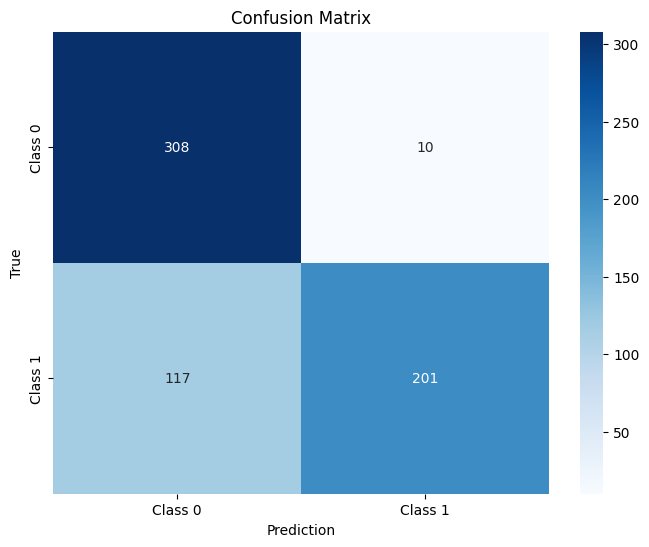

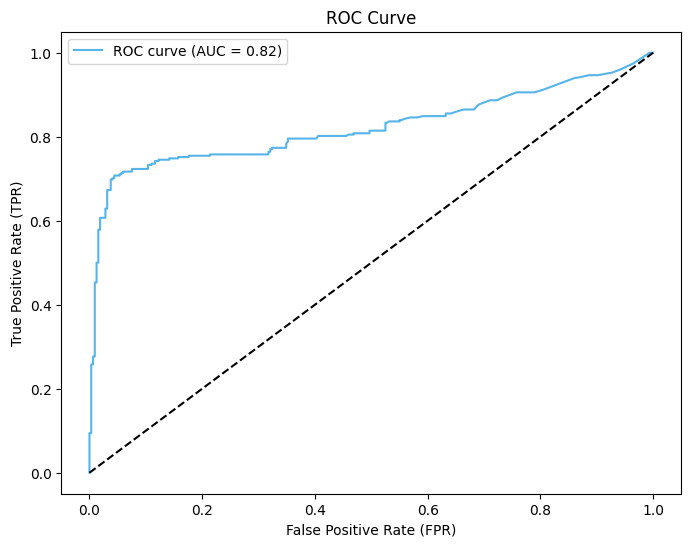

Class distribution in y_test: {0: 318, 1: 318}
Optimal threshold: 0.36027970910072327

Classification Report with Adjusted Threshold:

              precision    recall  f1-score   support

           0       0.76      0.96      0.85       318
           1       0.94      0.70      0.81       318

    accuracy                           0.83       636
   macro avg       0.85      0.83      0.83       636
weighted avg       0.85      0.83      0.83       636



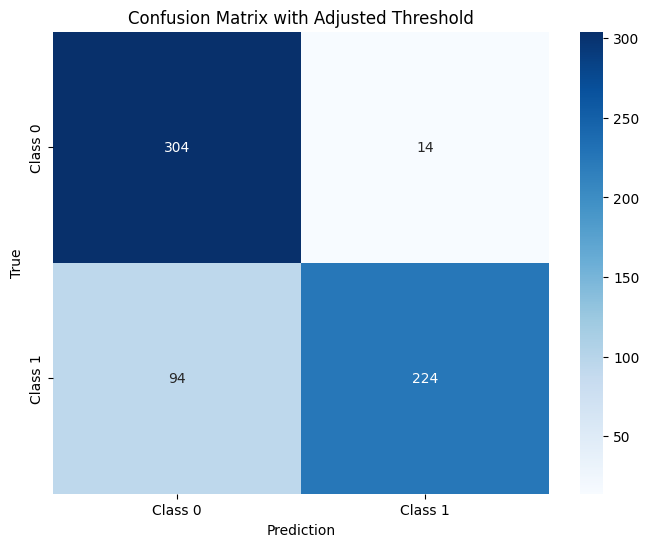

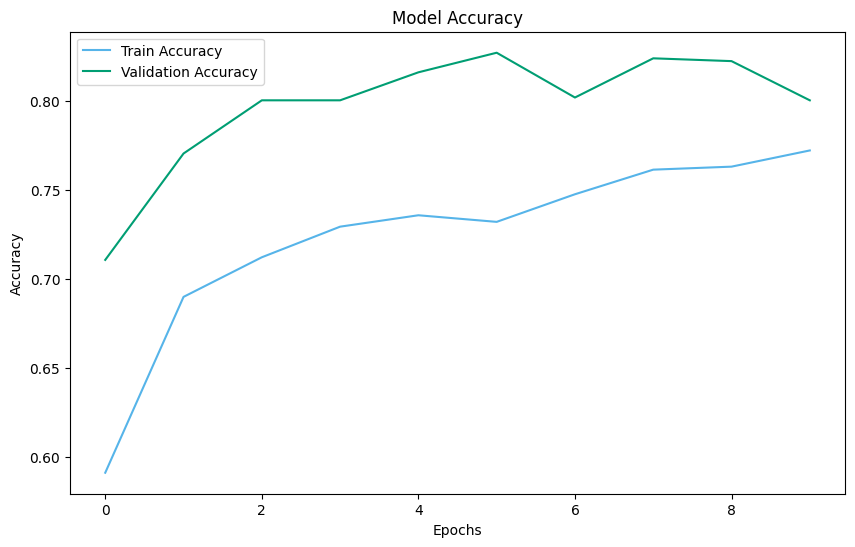

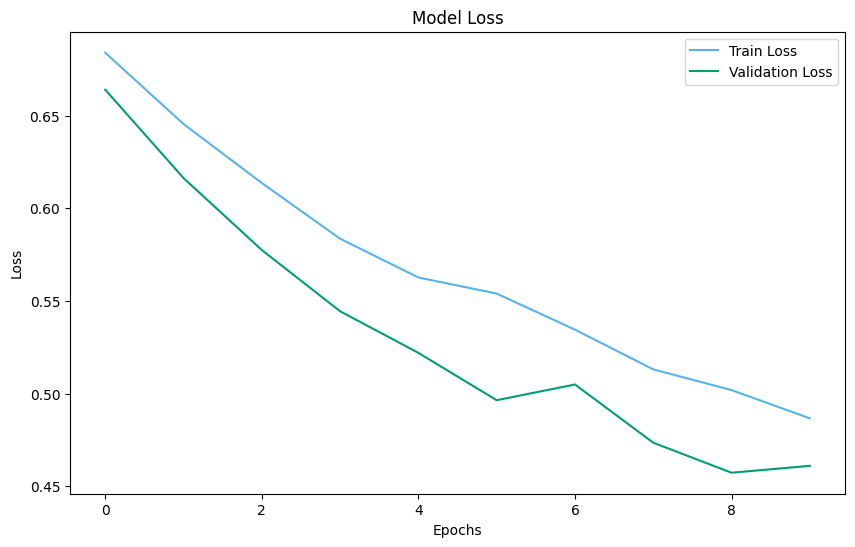

In [ ]:
# Step 1: Define the Vanilla RNN model

# Add more parameter
input_shape = X_train.shape[1:]  # (max_seq_length, n_features)
learning_rate = 0.001
batch_size = 32
epochs = 50

# Model
model = Sequential([
    Input(shape=input_shape),
    Masking(mask_value=0.0),  # Apply masking to handle padded sequences
    SimpleRNN(128, activation='tanh', return_sequences=False),
    Dense(1, activation='sigmoid')
])

# Dropout for regularization
model.add(Dropout(0.2))

# Add a Dense hidden layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# Output layer (binary classification: suspended or not)
model.add(Dense(1, activation='sigmoid'))

# Step 2: Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Step 3: Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=2)

# Step 4: Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Step 5: Additional metrics
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Verify class distribution in the test set
unique, counts = np.unique(y_test, return_counts=True)
print(f"Class distribution in y_test: {dict(zip(unique, counts))}")

# Adjust decision threshold based on precision-recall trade-off
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
optimal_idx = np.argmax(precision + recall)  # Maximizes precision + recall
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold}")

y_pred_adjusted = (y_pred_prob > optimal_threshold).astype(int)

# Recalculate metrics with the adjusted threshold
print("\nClassification Report with Adjusted Threshold:\n")
print(classification_report(y_test, y_pred_adjusted))

cm_adjusted = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix with Adjusted Threshold')
plt.show()

# Plot training and validation loss/accuracy
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


**Performance Metrics**

Test Loss: 0.4611
Test Accuracy: 80.03%
The model correctly predicts employee suspension status 80.03% of the time on unseen data.
ROC-AUC: 0.82
The model demonstrates strong discriminative ability, effectively distinguishing between suspended and non-suspended employees.

**Classification Performance**
Initial Threshold (0.5):

Precision:
Non-Suspensions (Class 0): 72%
Suspensions (Class 1): 95%
Recall:
Non-Suspensions: 97%
Suspensions: 63%
F1-Score:
Non-Suspensions: 0.83
Suspensions: 0.76
Overall Accuracy: 80%

Adjusted Threshold (Optimal = 0.3603):

Precision:
Non-Suspensions (Class 0): 76%
Suspensions (Class 1): 94%
Recall:
Non-Suspensions: 96%
Suspensions: 70%
F1-Score:
Non-Suspensions: 0.85
Suspensions: 0.81
Overall Accuracy: 83%

Adjusting the decision threshold improved the overall accuracy from 80% to 83%.




# Optuna (RNN)

[I 2025-01-13 20:09:32,641] A new study created in memory with name: no-name-09146954-36c5-4b27-9c50-4efab9531e6e


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-01-13 20:09:56,798] Trial 0 finished with value: -0.971707971057353 and parameters: {'rnn_units': 256, 'dense_units': 48, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0007417083376220151, 'batch_size': 32, 'rnn_activation': 'tanh'}. Best is trial 0 with value: -0.971707971057353.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2025-01-13 20:10:24,708] Trial 1 finished with value: -0.9094162181345005 and parameters: {'rnn_units': 96, 'dense_units': 16, 'dropout_rate': 0.30000000000000004, 'learning_rate': 6.320328372218458e-05, 'batch_size': 32, 'rnn_activation': 'relu'}. Best is trial 0 with value: -0.971707971057353.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2025-01-13 20:10:41,996] Trial 2 finished with value: -0.8191084560635634 and parameters: {'rnn_units': 160, 'dense_units': 16, 'dropout_rate': 0.5, 'learning_rate': 2.0199188047001972e-05, 'batch_size': 128, 'rnn_activation': 'relu'}. Best is trial 0 with value: -0.971707971057353.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-01-13 20:10:58,169] Trial 3 finished with value: -0.9637132548648488 and parameters: {'rnn_units': 256, 'dense_units': 96, 'dropout_rate': 0.4, 'learning_rate': 0.0002147460011668814, 'batch_size': 64, 'rnn_activation': 'relu'}. Best is trial 0 with value: -0.971707971057353.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-01-13 20:11:18,897] Trial 4 finished with value: -0.9567930443011771 and parameters: {'rnn_units': 256, 'dense_units': 16, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0002884336255602316, 'batch_size': 128, 'rnn_activation': 'tanh'}. Best is trial 0 with value: -0.971707971057353.
[I 2025-01-13 20:11:24,803] Trial 5 pruned. Trial was pruned at epoch 3.
[I 2025-01-13 20:11:27,022] Trial 6 pruned. Trial was pruned at epoch 0.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-01-13 20:11:36,251] Trial 7 finished with value: -0.9637724019636837 and parameters: {'rnn_units': 192, 'dense_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.006370287078991511, 'batch_size': 128, 'rnn_activation': 'swish'}. Best is trial 0 with value: -0.971707971057353.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2025-01-13 20:11:45,967] Trial 8 finished with value: -0.9723783048441473 and parameters: {'rnn_units': 96, 'dense_units': 32, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0017075302098980413, 'batch_size': 32, 'rnn_activation': 'relu'}. Best is trial 8 with value: -0.9723783048441473.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2025-01-13 20:11:58,473] Trial 9 finished with value: -0.9600264190374795 and parameters: {'rnn_units': 96, 'dense_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.0016961358894088715, 'batch_size': 32, 'rnn_activation': 'tanh'}. Best is trial 8 with value: -0.9723783048441473.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2025-01-13 20:12:05,591] Trial 10 finished with value: -0.9749610614932672 and parameters: {'rnn_units': 160, 'dense_units': 48, 'dropout_rate': 0.1, 'learning_rate': 0.0018303690186367537, 'batch_size': 64, 'rnn_activation': 'relu'}. Best is trial 10 with value: -0.9749610614932672.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2025-01-13 20:12:13,699] Trial 11 finished with value: -0.9683858756727982 and parameters: {'rnn_units': 160, 'dense_units': 48, 'dropout_rate': 0.1, 'learning_rate': 0.0017138666776706016, 'batch_size': 64, 'rnn_activation': 'relu'}. Best is trial 10 with value: -0.9749610614932672.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2025-01-13 20:12:20,390] Trial 12 finished with value: -0.9712446521164805 and parameters: {'rnn_units': 128, 'dense_units': 48, 'dropout_rate': 0.1, 'learning_rate': 0.0015069077555674984, 'batch_size': 64, 'rnn_activation': 'relu'}. Best is trial 10 with value: -0.9749610614932672.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-01-13 20:12:30,200] Trial 13 finished with value: -0.9675873898385284 and parameters: {'rnn_units': 192, 'dense_units': 80, 'dropout_rate': 0.2, 'learning_rate': 0.0007268066150515943, 'batch_size': 64, 'rnn_activation': 'relu'}. Best is trial 10 with value: -0.9749610614932672.
[I 2025-01-13 20:12:32,347] Trial 14 pruned. Trial was pruned at epoch 0.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2025-01-13 20:12:40,615] Trial 15 finished with value: -0.9612980816624277 and parameters: {'rnn_units': 128, 'dense_units': 80, 'dropout_rate': 0.2, 'learning_rate': 0.0028414463492755777, 'batch_size': 32, 'rnn_activation': 'relu'}. Best is trial 10 with value: -0.9749610614932672.
[I 2025-01-13 20:12:43,107] Trial 16 pruned. Trial was pruned at epoch 0.
[I 2025-01-13 20:12:45,331] Trial 17 pruned. Trial was pruned at epoch 0.
[I 2025-01-13 20:12:57,227] Trial 18 pruned. Trial was pruned at epoch 0.
[I 2025-01-13 20:13:00,145] Trial 19 pruned. Trial was pruned at epoch 1.
[I 2025-01-13 20:13:02,504] Trial 20 pruned. Trial was pruned at epoch 0.
[I 2025-01-13 20:13:07,387] Trial 21 pruned. Trial was pruned at epoch 2.
[I 2025-01-13 20:13:10,310] Trial 22 pruned. Trial was pruned at epoch 0.
[I 2025-01-13 20:13:13,198] Trial 23 pruned. Trial was pruned at epoch 0.
[I 2025-01-13 20:13:15,851] Trial 24 pruned. Trial was pruned at epoch 0.
[I 2025-01-13 20:13:19,217] Trial 25 pruned. T

Best hyperparameters: {'rnn_units': 160, 'dense_units': 48, 'dropout_rate': 0.1, 'learning_rate': 0.0018303690186367537, 'batch_size': 64, 'rnn_activation': 'relu'}
Epoch 1/50
47/47 - 2s - 48ms/step - accuracy: 0.7499 - loss: 0.5306 - val_accuracy: 0.7802 - val_loss: 0.4677
Epoch 2/50
47/47 - 0s - 10ms/step - accuracy: 0.7934 - loss: 0.4525 - val_accuracy: 0.8257 - val_loss: 0.4259
Epoch 3/50
47/47 - 0s - 10ms/step - accuracy: 0.8413 - loss: 0.3809 - val_accuracy: 0.8210 - val_loss: 0.3931
Epoch 4/50
47/47 - 0s - 10ms/step - accuracy: 0.8878 - loss: 0.2847 - val_accuracy: 0.8885 - val_loss: 0.2944
Epoch 5/50
47/47 - 0s - 10ms/step - accuracy: 0.9306 - loss: 0.1856 - val_accuracy: 0.8697 - val_loss: 0.2928
Epoch 6/50
47/47 - 0s - 10ms/step - accuracy: 0.9494 - loss: 0.1303 - val_accuracy: 0.9089 - val_loss: 0.2510
Epoch 7/50
47/47 - 0s - 10ms/step - accuracy: 0.9703 - loss: 0.0783 - val_accuracy: 0.9341 - val_loss: 0.1915
Epoch 8/50
47/47 - 0s - 9ms/step - accuracy: 0.9747 - loss: 0.067

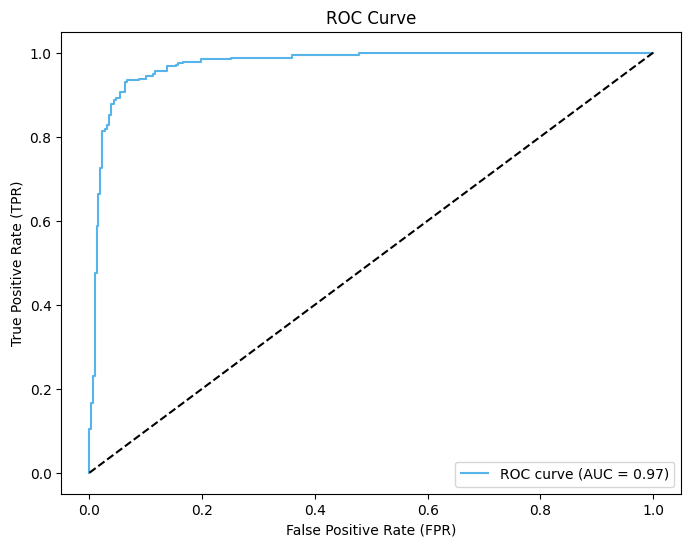

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    rnn_units = trial.suggest_int('rnn_units', 64, 256, step=32)
    dense_units = trial.suggest_int('dense_units', 16, 128, step=16)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    rnn_activation = trial.suggest_categorical('rnn_activation', ['tanh', 'relu', 'swish'])

    # Build the model
    model = Sequential([
        Input(shape=X_train.shape[1:]),  # Input shape (sequence_length, features)
        Masking(mask_value=0.0),        # Mask padded sequences
        SimpleRNN(rnn_units, activation=rnn_activation),  # RNN layer with dynamic activation
        Dropout(dropout_rate),                        # Dropout for regularization
        Dense(dense_units, activation='relu'),        # Dense hidden layer
        Dropout(dropout_rate),                        # Dropout after dense
        Dense(1, activation='sigmoid')                # Output layer
    ])

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),  # Use validation set explicitly
        batch_size=batch_size,
        epochs=50,
        verbose=0,  # Suppress output during training
        callbacks=[early_stopping, optuna.integration.TFKerasPruningCallback(trial, 'val_loss')]
    )

    # Evaluate the model on the validation set
    val_predictions = model.predict(X_val).ravel()
    roc_auc = roc_auc_score(y_val, val_predictions)  # Use ROC-AUC as the optimization metric
    return -roc_auc  # Maximize ROC-AUC by minimizing its negative value

# Create the Optuna study
study = optuna.create_study(direction='minimize')  # Minimize the negative ROC-AUC
study.optimize(objective, n_trials=30)  # Perform 30 trials

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Train the model with the best hyperparameters
best_params = study.best_params

model = Sequential([
    Input(shape=X_train.shape[1:]),
    Masking(mask_value=0.0),
    SimpleRNN(best_params['rnn_units'], activation=best_params['rnn_activation']),
    Dropout(best_params['dropout_rate']),
    Dense(best_params['dense_units'], activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=best_params['learning_rate'])
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # Use validation set
    batch_size=best_params['batch_size'],
    epochs=50,
    callbacks=[early_stopping],
    verbose=2
)

# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions and evaluate the results
y_pred_prob = model.predict(X_test).ravel()
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC: {roc_auc:.4f}")

y_pred = (y_pred_prob > 0.5).astype(int)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()


**Performance Metrics**

Test Loss: 0.2154
Test Accuracy: 93.40%
The model correctly predicts employee suspension status in 93.4% of cases on unseen data.
ROC-AUC: 0.9731
The model demonstrates exceptional discriminative ability, effectively distinguishing between suspended and non-suspended employees.

**Classification Report**
Precision:
Non-Suspensions (Class 0): 93%
Suspensions (Class 1): 93%
Recall:
Non-Suspensions (Class 0): 93%
Suspensions (Class 1): 93%
F1-Score:
Non-Suspensions (Class 0): 0.93
Suspensions (Class 1): 0.93
Overall Accuracy: 93.40%
Macro and Weighted Averages:
Precision, Recall, and F1-Scores: 0.93

ROC-AUC of 0.9731, the model shows excellent capability to distinguish between the two classes










# Keras Tuner (RNN)

Reloading Tuner from my_dir/rnn_tuning/tuner0.json
Best Hyperparameters: {'rnn_units': 192, 'dropout_rate': 0.1, 'dense_units': 112, 'learning_rate': 0.0005301182854479577}
Epoch 1/50
93/93 - 2s - 27ms/step - accuracy: 0.7428 - loss: 0.5339 - val_accuracy: 0.8132 - val_loss: 0.4517
Epoch 2/50
93/93 - 1s - 8ms/step - accuracy: 0.8008 - loss: 0.4461 - val_accuracy: 0.8022 - val_loss: 0.4314
Epoch 3/50
93/93 - 1s - 8ms/step - accuracy: 0.8288 - loss: 0.3968 - val_accuracy: 0.8242 - val_loss: 0.3870
Epoch 4/50
93/93 - 1s - 8ms/step - accuracy: 0.8490 - loss: 0.3566 - val_accuracy: 0.8619 - val_loss: 0.3555
Epoch 5/50
93/93 - 1s - 8ms/step - accuracy: 0.8746 - loss: 0.3151 - val_accuracy: 0.8556 - val_loss: 0.3522
Epoch 6/50
93/93 - 1s - 8ms/step - accuracy: 0.8891 - loss: 0.2814 - val_accuracy: 0.8964 - val_loss: 0.3135
Epoch 7/50
93/93 - 1s - 8ms/step - accuracy: 0.9110 - loss: 0.2369 - val_accuracy: 0.8807 - val_loss: 0.3311
Epoch 8/50
93/93 - 1s - 8ms/step - accuracy: 0.9269 - loss: 0.2

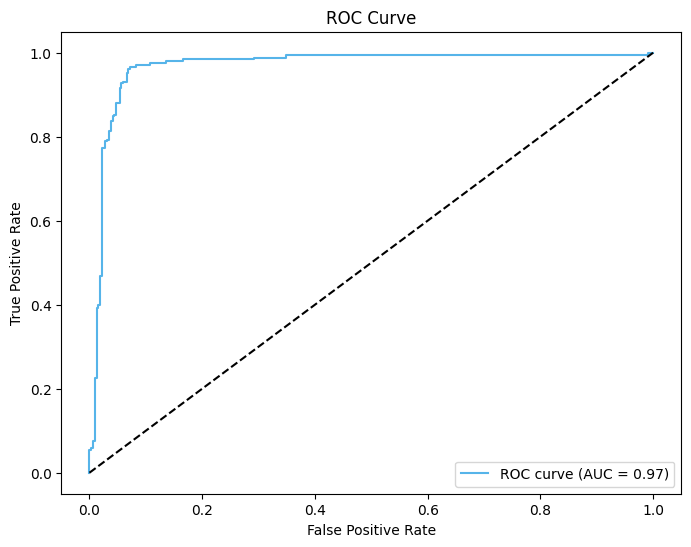


Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       318
           1       0.92      0.97      0.94       318

    accuracy                           0.94       636
   macro avg       0.94      0.94      0.94       636
weighted avg       0.94      0.94      0.94       636



In [ ]:
# Define the model-building function
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=X_train.shape[1:]))
    model.add(Masking(mask_value=0.0))

    # RNN units
    model.add(SimpleRNN(
        units=hp.Int('rnn_units', min_value=96, max_value=160, step=32),
        activation='tanh'
    ))

    # Dropout rate
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.4, step=0.05)))

    # Dense layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=64, step=16),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.4, step=0.05)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Learning rate
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-3, max_value=5e-3, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=30,
    executions_per_trial=1,
    directory='my_dir',
    project_name='rnn_tuning'
)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Search for the best hyperparameters
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),  # Use the pre-defined validation set
    epochs=50,
    batch_size=32,  # Use a default batch size during the search
    callbacks=[early_stopping],
    verbose=2
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # Use the pre-defined validation set
    epochs=50,
    batch_size=32,  # Use the same batch size as during the search
    callbacks=[early_stopping],
    verbose=2
)

# Evaluate on test data
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions and compute ROC AUC
y_pred_prob = best_model.predict(X_test).ravel()
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC: {roc_auc:.4f}")

# Plot the ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Print classification report
y_pred = (y_pred_prob > 0.5).astype(int)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))



**Performance Metrics**
Test Loss: 0.2334
Test Accuracy: 94.34%
The model correctly predicts employee suspension status in 94.3% of cases on unseen data.
ROC-AUC: 0.9675
The model exhibits excellent discriminative ability, with a high capability to distinguish between suspended and non-suspended employees.

**Classification Report**
Precision:
Non-Suspensions (Class 0): 97%
Suspensions (Class 1): 92%
Recall:
Non-Suspensions (Class 0): 92%
Suspensions (Class 1): 97%
F1-Score:
Non-Suspensions (Class 0): 0.94
Suspensions (Class 1): 0.94
Overall Accuracy: 94.34%
Macro and Weighted Averages:
Precision, Recall, and F1-Scores: 0.94


The model achieved a ROC-AUC of 0.97, indicating exceptional discriminative power between the two classes.


# GRU

Epoch 1/50
47/47 - 3s - 66ms/step - accuracy: 0.6886 - loss: 0.6071 - val_accuracy: 0.7799 - val_loss: 0.5031
Epoch 2/50
47/47 - 1s - 16ms/step - accuracy: 0.7321 - loss: 0.5464 - val_accuracy: 0.7925 - val_loss: 0.4730
Epoch 3/50
47/47 - 1s - 16ms/step - accuracy: 0.7526 - loss: 0.5269 - val_accuracy: 0.8050 - val_loss: 0.4656
Epoch 4/50
47/47 - 1s - 16ms/step - accuracy: 0.7654 - loss: 0.5061 - val_accuracy: 0.8302 - val_loss: 0.4442
Epoch 5/50
47/47 - 1s - 16ms/step - accuracy: 0.7681 - loss: 0.4956 - val_accuracy: 0.8223 - val_loss: 0.4333
Epoch 6/50
47/47 - 1s - 16ms/step - accuracy: 0.7769 - loss: 0.4891 - val_accuracy: 0.8270 - val_loss: 0.4392
Epoch 7/50
47/47 - 1s - 16ms/step - accuracy: 0.7705 - loss: 0.4880 - val_accuracy: 0.8129 - val_loss: 0.4297
Epoch 8/50
47/47 - 1s - 16ms/step - accuracy: 0.7782 - loss: 0.4739 - val_accuracy: 0.8318 - val_loss: 0.4141
Epoch 9/50
47/47 - 1s - 16ms/step - accuracy: 0.7809 - loss: 0.4788 - val_accuracy: 0.8318 - val_loss: 0.4064
Epoch 10/5

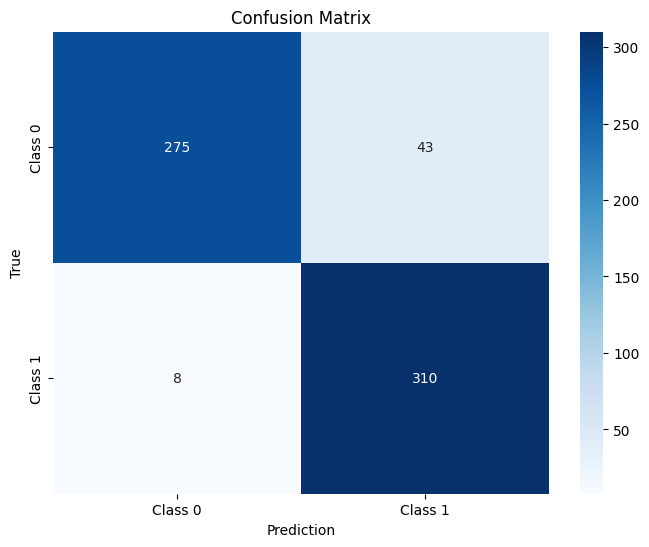

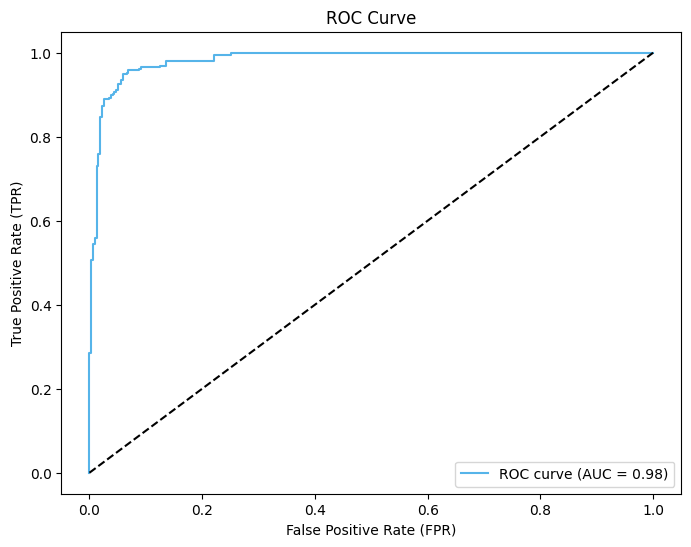

Class distribution in y_test: {0: 318, 1: 318}
Optimal threshold: 0.8517814874649048

Classification Report with Adjusted Threshold:

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       318
           1       0.93      0.95      0.94       318

    accuracy                           0.94       636
   macro avg       0.94      0.94      0.94       636
weighted avg       0.94      0.94      0.94       636



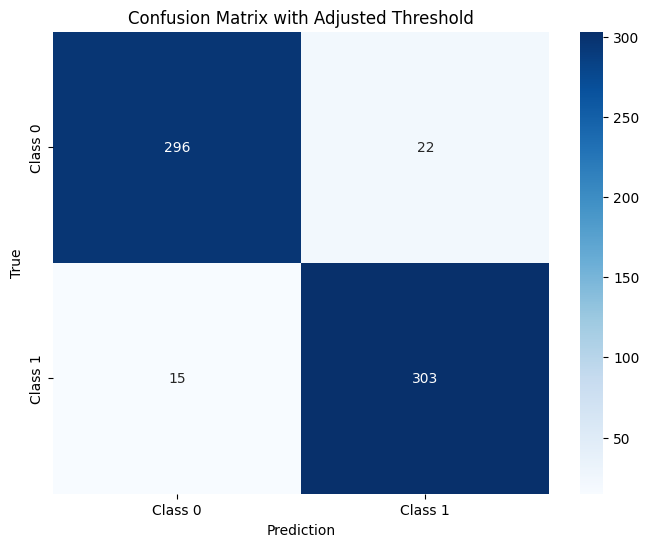

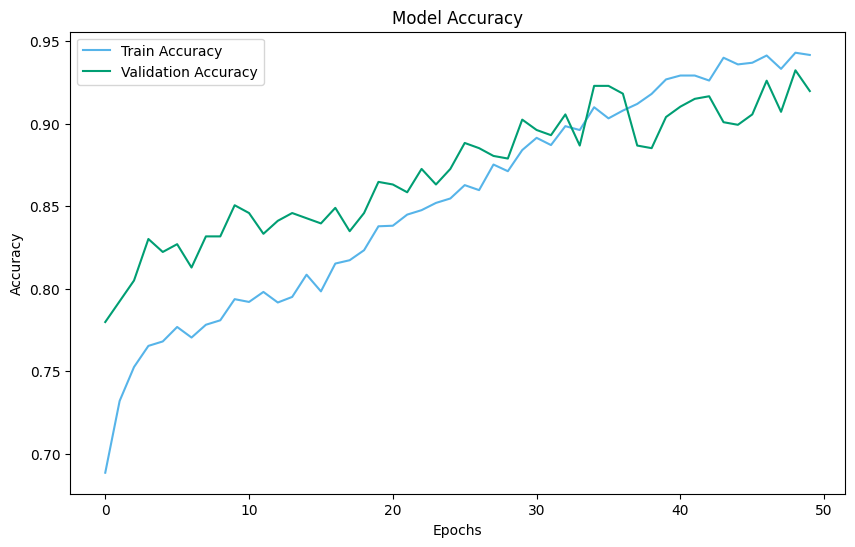

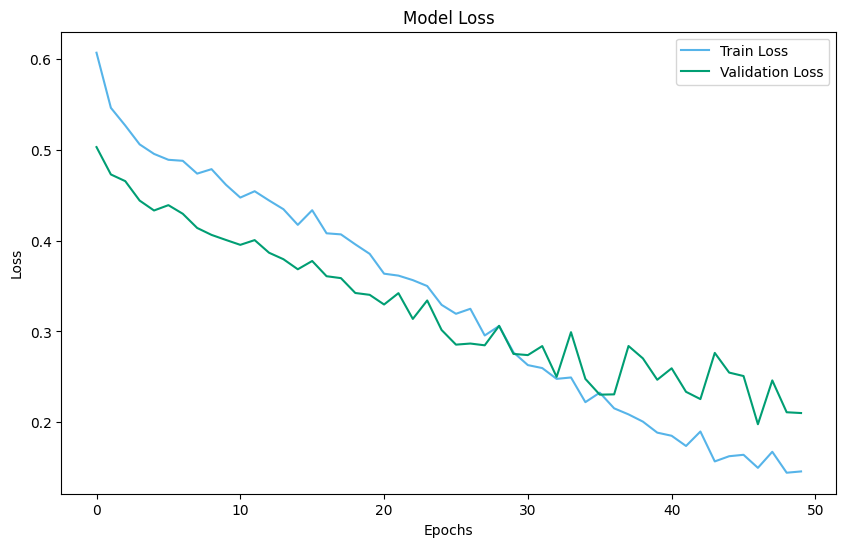

In [ ]:
# Step 1: Define the GRU model
input_shape = X_train.shape[1:]  # (max_seq_length, n_features)
learning_rate = 0.001
batch_size = 64
epochs = 50

model = Sequential([
    Input(shape=input_shape),  # Input layer
    Masking(mask_value=0.0),  # Masking layer to handle padded sequences
    GRU(128, activation='tanh', return_sequences=False, dropout=0.2),  # GRU layer with Dropout
    Dense(32, activation='relu'),  # Dense hidden layer
    Dropout(0.2),  # Dropout for regularization
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Step 2: Compile the model
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',  # Loss function for binary classification
    metrics=['accuracy']  # Metrics to track during training
)

# Step 3: Train the model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    verbose=2
)

# Step 4: Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Step 5: Additional metrics
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Verify class distribution in the test set
unique, counts = np.unique(y_test, return_counts=True)
print(f"Class distribution in y_test: {dict(zip(unique, counts))}")

# Adjust decision threshold based on precision-recall trade-off
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
optimal_idx = np.argmax(precision + recall)  # Maximizes precision + recall
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold}")

y_pred_adjusted = (y_pred_prob > optimal_threshold).astype(int)

# Recalculate metrics with the adjusted threshold
print("\nClassification Report with Adjusted Threshold:\n")
print(classification_report(y_test, y_pred_adjusted))

cm_adjusted = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix with Adjusted Threshold')
plt.show()

# Plot training and validation loss/accuracy
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


**Performance Metrics**

Test Loss: 0.2102
Test Accuracy: 91.98%
The model achieves an accuracy of 91.98% on unseen data, correctly predicting employee suspension status with high reliability.

**Classification Performance**
Initial Threshold (0.5):
Precision:
Non-Suspensions (Class 0): 97%
Suspensions (Class 1): 88%
Recall:
Non-Suspensions (Class 0): 86%
Suspensions (Class 1): 97%
F1-Score:
Non-Suspensions (Class 0): 0.92
Suspensions (Class 1): 0.92
Overall Accuracy: 91.98%
Adjusted Threshold (Optimal = 0.8518):

Precision:
Non-Suspensions (Class 0): 95%
Suspensions (Class 1): 93%
Recall:
Non-Suspensions (Class 0): 93%
Suspensions (Class 1): 95%
F1-Score:
Non-Suspensions (Class 0): 0.94
Suspensions (Class 1): 0.94
Overall Accuracy: 94%

By optimizing the threshold, the model's accuracy increased from 91.98% to 94%, showing improved generalization and robustness on unseen data.

# Optuna (GRU)

[I 2025-01-13 20:39:47,902] A new study created in memory with name: no-name-52e68fc2-c975-4d51-9e6b-206e065de039


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


[I 2025-01-13 20:40:06,112] Trial 0 finished with value: 0.7227191413237924 and parameters: {'learning_rate': 5.4689327299716834e-05, 'gru_units': 224, 'dense_units': 16, 'dropout_rate': 0.30000000000000004, 'batch_size': 32, 'rnn_activation': 'tanh'}. Best is trial 0 with value: 0.7227191413237924.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-01-13 20:40:15,364] Trial 1 finished with value: 0.7323420074349442 and parameters: {'learning_rate': 0.0006356238154109155, 'gru_units': 96, 'dense_units': 32, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'rnn_activation': 'swish'}. Best is trial 1 with value: 0.7323420074349442.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-01-13 20:40:25,632] Trial 2 finished with value: 0.7295373665480427 and parameters: {'learning_rate': 6.26551646567177e-05, 'gru_units': 128, 'dense_units': 80, 'dropout_rate': 0.5, 'batch_size': 64, 'rnn_activation': 'swish'}. Best is trial 1 with value: 0.7323420074349442.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-01-13 20:40:42,400] Trial 3 finished with value: 0.7963525835866262 and parameters: {'learning_rate': 0.0010207509434976424, 'gru_units': 192, 'dense_units': 64, 'dropout_rate': 0.4, 'batch_size': 32, 'rnn_activation': 'tanh'}. Best is trial 3 with value: 0.7963525835866262.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-01-13 20:40:55,389] Trial 4 finished with value: 0.8541353383458647 and parameters: {'learning_rate': 0.003853148050666146, 'gru_units': 128, 'dense_units': 64, 'dropout_rate': 0.30000000000000004, 'batch_size': 32, 'rnn_activation': 'relu'}. Best is trial 4 with value: 0.8541353383458647.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-01-13 20:41:07,101] Trial 5 finished with value: 0.8026755852842811 and parameters: {'learning_rate': 0.0012339355472423732, 'gru_units': 192, 'dense_units': 48, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'rnn_activation': 'tanh'}. Best is trial 4 with value: 0.8541353383458647.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-01-13 20:41:14,400] Trial 6 finished with value: 0.7164179104477613 and parameters: {'learning_rate': 2.4955498764029342e-05, 'gru_units': 64, 'dense_units': 64, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'rnn_activation': 'relu'}. Best is trial 4 with value: 0.8541353383458647.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-01-13 20:41:23,824] Trial 7 finished with value: 0.8701095461658842 and parameters: {'learning_rate': 0.0037720476823270128, 'gru_units': 192, 'dense_units': 64, 'dropout_rate': 0.2, 'batch_size': 128, 'rnn_activation': 'tanh'}. Best is trial 7 with value: 0.8701095461658842.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-01-13 20:41:30,554] Trial 8 finished with value: 0.7292418772563177 and parameters: {'learning_rate': 0.00017387642377687953, 'gru_units': 96, 'dense_units': 96, 'dropout_rate': 0.4, 'batch_size': 128, 'rnn_activation': 'relu'}. Best is trial 7 with value: 0.8701095461658842.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-01-13 20:41:43,438] Trial 9 finished with value: 0.8424543946932006 and parameters: {'learning_rate': 0.0007866589761068146, 'gru_units': 128, 'dense_units': 80, 'dropout_rate': 0.1, 'batch_size': 32, 'rnn_activation': 'tanh'}. Best is trial 7 with value: 0.8701095461658842.


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


[I 2025-01-13 20:41:54,703] Trial 10 finished with value: 0.9214501510574018 and parameters: {'learning_rate': 0.008507220365578392, 'gru_units': 256, 'dense_units': 128, 'dropout_rate': 0.1, 'batch_size': 128, 'rnn_activation': 'tanh'}. Best is trial 10 with value: 0.9214501510574018.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-01-13 20:42:05,689] Trial 11 finished with value: 0.9061102831594636 and parameters: {'learning_rate': 0.008128575932827758, 'gru_units': 256, 'dense_units': 128, 'dropout_rate': 0.1, 'batch_size': 128, 'rnn_activation': 'tanh'}. Best is trial 10 with value: 0.9214501510574018.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2025-01-13 20:42:16,774] Trial 12 finished with value: 0.9183359013867488 and parameters: {'learning_rate': 0.007143628688619552, 'gru_units': 256, 'dense_units': 128, 'dropout_rate': 0.1, 'batch_size': 128, 'rnn_activation': 'tanh'}. Best is trial 10 with value: 0.9214501510574018.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-01-13 20:42:27,812] Trial 13 finished with value: 0.9180327868852458 and parameters: {'learning_rate': 0.0070504673034981835, 'gru_units': 256, 'dense_units': 128, 'dropout_rate': 0.1, 'batch_size': 128, 'rnn_activation': 'tanh'}. Best is trial 10 with value: 0.9214501510574018.


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


[I 2025-01-13 20:42:39,212] Trial 14 finished with value: 0.8557844690966719 and parameters: {'learning_rate': 0.00299248232460674, 'gru_units': 256, 'dense_units': 112, 'dropout_rate': 0.2, 'batch_size': 128, 'rnn_activation': 'tanh'}. Best is trial 10 with value: 0.9214501510574018.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-01-13 20:42:49,886] Trial 15 finished with value: 0.897590361445783 and parameters: {'learning_rate': 0.00991514838354409, 'gru_units': 224, 'dense_units': 112, 'dropout_rate': 0.2, 'batch_size': 128, 'rnn_activation': 'swish'}. Best is trial 10 with value: 0.9214501510574018.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-01-13 20:43:00,249] Trial 16 finished with value: 0.7708703374777975 and parameters: {'learning_rate': 0.00023767046584367163, 'gru_units': 224, 'dense_units': 112, 'dropout_rate': 0.1, 'batch_size': 128, 'rnn_activation': 'tanh'}. Best is trial 10 with value: 0.9214501510574018.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-01-13 20:43:11,804] Trial 17 finished with value: 0.84640522875817 and parameters: {'learning_rate': 0.00240552831442073, 'gru_units': 256, 'dense_units': 128, 'dropout_rate': 0.2, 'batch_size': 128, 'rnn_activation': 'tanh'}. Best is trial 10 with value: 0.9214501510574018.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-01-13 20:43:20,409] Trial 18 finished with value: 0.5824411134903641 and parameters: {'learning_rate': 1.1678612015130112e-05, 'gru_units': 160, 'dense_units': 96, 'dropout_rate': 0.1, 'batch_size': 128, 'rnn_activation': 'swish'}. Best is trial 10 with value: 0.9214501510574018.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-01-13 20:43:30,837] Trial 19 finished with value: 0.7908611599297012 and parameters: {'learning_rate': 0.0003678806691660513, 'gru_units': 224, 'dense_units': 96, 'dropout_rate': 0.2, 'batch_size': 128, 'rnn_activation': 'relu'}. Best is trial 10 with value: 0.9214501510574018.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-01-13 20:43:39,335] Trial 20 finished with value: 0.8034482758620689 and parameters: {'learning_rate': 0.00144732945819169, 'gru_units': 160, 'dense_units': 112, 'dropout_rate': 0.1, 'batch_size': 128, 'rnn_activation': 'tanh'}. Best is trial 10 with value: 0.9214501510574018.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-01-13 20:43:50,451] Trial 21 finished with value: 0.8965517241379309 and parameters: {'learning_rate': 0.005901607086899286, 'gru_units': 256, 'dense_units': 128, 'dropout_rate': 0.1, 'batch_size': 128, 'rnn_activation': 'tanh'}. Best is trial 10 with value: 0.9214501510574018.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-01-13 20:44:01,613] Trial 22 finished with value: 0.916913946587537 and parameters: {'learning_rate': 0.005165251642280375, 'gru_units': 256, 'dense_units': 128, 'dropout_rate': 0.1, 'batch_size': 128, 'rnn_activation': 'tanh'}. Best is trial 10 with value: 0.9214501510574018.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-01-13 20:44:12,093] Trial 23 finished with value: 0.8286189683860233 and parameters: {'learning_rate': 0.0017898521256565234, 'gru_units': 224, 'dense_units': 128, 'dropout_rate': 0.2, 'batch_size': 128, 'rnn_activation': 'tanh'}. Best is trial 10 with value: 0.9214501510574018.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-01-13 20:44:23,276] Trial 24 finished with value: 0.9280245022970903 and parameters: {'learning_rate': 0.007096868185105534, 'gru_units': 256, 'dense_units': 112, 'dropout_rate': 0.1, 'batch_size': 128, 'rnn_activation': 'tanh'}. Best is trial 24 with value: 0.9280245022970903.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-01-13 20:44:32,730] Trial 25 finished with value: 0.9014925373134328 and parameters: {'learning_rate': 0.009792726868847478, 'gru_units': 192, 'dense_units': 112, 'dropout_rate': 0.2, 'batch_size': 128, 'rnn_activation': 'tanh'}. Best is trial 24 with value: 0.9280245022970903.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-01-13 20:44:42,836] Trial 26 finished with value: 0.870253164556962 and parameters: {'learning_rate': 0.002474978217080917, 'gru_units': 224, 'dense_units': 96, 'dropout_rate': 0.1, 'batch_size': 128, 'rnn_activation': 'tanh'}. Best is trial 24 with value: 0.9280245022970903.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-01-13 20:44:53,869] Trial 27 finished with value: 0.8089887640449438 and parameters: {'learning_rate': 0.004511288665006478, 'gru_units': 256, 'dense_units': 112, 'dropout_rate': 0.4, 'batch_size': 128, 'rnn_activation': 'tanh'}. Best is trial 24 with value: 0.9280245022970903.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2025-01-13 20:45:11,690] Trial 28 finished with value: 0.8062827225130891 and parameters: {'learning_rate': 0.0004632418323739604, 'gru_units': 224, 'dense_units': 128, 'dropout_rate': 0.2, 'batch_size': 32, 'rnn_activation': 'relu'}. Best is trial 24 with value: 0.9280245022970903.


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


[I 2025-01-13 20:45:25,131] Trial 29 finished with value: 0.8031746031746032 and parameters: {'learning_rate': 0.005686993545819952, 'gru_units': 224, 'dense_units': 16, 'dropout_rate': 0.5, 'batch_size': 64, 'rnn_activation': 'swish'}. Best is trial 24 with value: 0.9280245022970903.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-01-13 20:45:40,268] Trial 30 finished with value: 0.7540394973070016 and parameters: {'learning_rate': 6.461937753509566e-05, 'gru_units': 160, 'dense_units': 80, 'dropout_rate': 0.1, 'batch_size': 32, 'rnn_activation': 'tanh'}. Best is trial 24 with value: 0.9280245022970903.


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


[I 2025-01-13 20:45:51,350] Trial 31 finished with value: 0.9080118694362018 and parameters: {'learning_rate': 0.007117733392886542, 'gru_units': 256, 'dense_units': 128, 'dropout_rate': 0.1, 'batch_size': 128, 'rnn_activation': 'tanh'}. Best is trial 24 with value: 0.9280245022970903.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-01-13 20:46:03,151] Trial 32 finished with value: 0.858044164037855 and parameters: {'learning_rate': 0.0019467811241667108, 'gru_units': 256, 'dense_units': 112, 'dropout_rate': 0.1, 'batch_size': 128, 'rnn_activation': 'tanh'}. Best is trial 24 with value: 0.9280245022970903.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2025-01-13 20:46:14,748] Trial 33 finished with value: 0.867579908675799 and parameters: {'learning_rate': 0.0032298970390792522, 'gru_units': 256, 'dense_units': 128, 'dropout_rate': 0.1, 'batch_size': 128, 'rnn_activation': 'tanh'}. Best is trial 24 with value: 0.9280245022970903.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-01-13 20:46:27,368] Trial 34 finished with value: 0.8968609865470852 and parameters: {'learning_rate': 0.006351717660416148, 'gru_units': 224, 'dense_units': 96, 'dropout_rate': 0.2, 'batch_size': 64, 'rnn_activation': 'tanh'}. Best is trial 24 with value: 0.9280245022970903.


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


[I 2025-01-13 20:46:39,068] Trial 35 finished with value: 0.8795518207282913 and parameters: {'learning_rate': 0.009533251355971882, 'gru_units': 256, 'dense_units': 128, 'dropout_rate': 0.1, 'batch_size': 128, 'rnn_activation': 'swish'}. Best is trial 24 with value: 0.9280245022970903.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-01-13 20:46:48,497] Trial 36 finished with value: 0.7410071942446043 and parameters: {'learning_rate': 0.00012508950460094246, 'gru_units': 192, 'dense_units': 48, 'dropout_rate': 0.1, 'batch_size': 128, 'rnn_activation': 'tanh'}. Best is trial 24 with value: 0.9280245022970903.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2025-01-13 20:47:09,096] Trial 37 finished with value: 0.9247311827956989 and parameters: {'learning_rate': 0.00410860286083604, 'gru_units': 256, 'dense_units': 112, 'dropout_rate': 0.2, 'batch_size': 32, 'rnn_activation': 'tanh'}. Best is trial 24 with value: 0.9280245022970903.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-01-13 20:47:27,045] Trial 38 finished with value: 0.903903903903904 and parameters: {'learning_rate': 0.0039048564345627477, 'gru_units': 224, 'dense_units': 112, 'dropout_rate': 0.2, 'batch_size': 32, 'rnn_activation': 'relu'}. Best is trial 24 with value: 0.9280245022970903.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-01-13 20:47:43,960] Trial 39 finished with value: 0.8223684210526316 and parameters: {'learning_rate': 0.0009320476875258167, 'gru_units': 192, 'dense_units': 96, 'dropout_rate': 0.30000000000000004, 'batch_size': 32, 'rnn_activation': 'tanh'}. Best is trial 24 with value: 0.9280245022970903.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-01-13 20:47:54,625] Trial 40 finished with value: 0.7758007117437721 and parameters: {'learning_rate': 0.0014311719302752537, 'gru_units': 64, 'dense_units': 80, 'dropout_rate': 0.2, 'batch_size': 32, 'rnn_activation': 'swish'}. Best is trial 24 with value: 0.9280245022970903.


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


[I 2025-01-13 20:48:14,727] Trial 41 finished with value: 0.9404388714733543 and parameters: {'learning_rate': 0.00507863449873296, 'gru_units': 256, 'dense_units': 112, 'dropout_rate': 0.1, 'batch_size': 32, 'rnn_activation': 'tanh'}. Best is trial 41 with value: 0.9404388714733543.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-01-13 20:48:34,977] Trial 42 finished with value: 0.924219910846954 and parameters: {'learning_rate': 0.004459919653697658, 'gru_units': 256, 'dense_units': 112, 'dropout_rate': 0.1, 'batch_size': 32, 'rnn_activation': 'tanh'}. Best is trial 41 with value: 0.9404388714733543.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-01-13 20:48:55,001] Trial 43 finished with value: 0.9341500765696784 and parameters: {'learning_rate': 0.004237539415947487, 'gru_units': 256, 'dense_units': 112, 'dropout_rate': 0.1, 'batch_size': 32, 'rnn_activation': 'tanh'}. Best is trial 41 with value: 0.9404388714733543.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-01-13 20:49:15,124] Trial 44 finished with value: 0.9047619047619048 and parameters: {'learning_rate': 0.004205243005964941, 'gru_units': 256, 'dense_units': 96, 'dropout_rate': 0.2, 'batch_size': 32, 'rnn_activation': 'tanh'}. Best is trial 41 with value: 0.9404388714733543.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-01-13 20:49:33,492] Trial 45 finished with value: 0.9099099099099099 and parameters: {'learning_rate': 0.0022482942049521643, 'gru_units': 224, 'dense_units': 112, 'dropout_rate': 0.1, 'batch_size': 32, 'rnn_activation': 'tanh'}. Best is trial 41 with value: 0.9404388714733543.


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


[I 2025-01-13 20:49:53,494] Trial 46 finished with value: 0.82907133243607 and parameters: {'learning_rate': 0.0030688070297898488, 'gru_units': 256, 'dense_units': 80, 'dropout_rate': 0.30000000000000004, 'batch_size': 32, 'rnn_activation': 'tanh'}. Best is trial 41 with value: 0.9404388714733543.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-01-13 20:50:10,409] Trial 47 finished with value: 0.8 and parameters: {'learning_rate': 0.0010884625924187925, 'gru_units': 192, 'dense_units': 96, 'dropout_rate': 0.4, 'batch_size': 32, 'rnn_activation': 'relu'}. Best is trial 41 with value: 0.9404388714733543.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-01-13 20:50:23,958] Trial 48 finished with value: 0.9203007518796993 and parameters: {'learning_rate': 0.004510531330248626, 'gru_units': 128, 'dense_units': 112, 'dropout_rate': 0.1, 'batch_size': 32, 'rnn_activation': 'tanh'}. Best is trial 41 with value: 0.9404388714733543.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-01-13 20:50:35,696] Trial 49 finished with value: 0.8830409356725146 and parameters: {'learning_rate': 0.00292872345366612, 'gru_units': 96, 'dense_units': 48, 'dropout_rate': 0.1, 'batch_size': 32, 'rnn_activation': 'tanh'}. Best is trial 41 with value: 0.9404388714733543.


Best hyperparameters:
{'learning_rate': 0.00507863449873296, 'gru_units': 256, 'dense_units': 112, 'dropout_rate': 0.1, 'batch_size': 32, 'rnn_activation': 'tanh'}

Best trial metrics:
Accuracy: 0.9403
Precision: 0.9375
Recall: 0.9434
F1 Score: 0.9404
ROC-AUC: 0.9738
Epoch 1/50
93/93 - 4s - 43ms/step - accuracy: 0.7597 - loss: 0.5229 - val_accuracy: 0.7881 - val_loss: 0.4754
Epoch 2/50
93/93 - 2s - 19ms/step - accuracy: 0.7738 - loss: 0.4893 - val_accuracy: 0.7865 - val_loss: 0.4259
Epoch 3/50
93/93 - 2s - 19ms/step - accuracy: 0.7883 - loss: 0.4575 - val_accuracy: 0.8163 - val_loss: 0.4002
Epoch 4/50
93/93 - 2s - 19ms/step - accuracy: 0.8271 - loss: 0.3893 - val_accuracy: 0.8414 - val_loss: 0.3634
Epoch 5/50
93/93 - 2s - 18ms/step - accuracy: 0.8440 - loss: 0.3585 - val_accuracy: 0.8791 - val_loss: 0.2961
Epoch 6/50
93/93 - 2s - 19ms/step - accuracy: 0.8915 - loss: 0.2753 - val_accuracy: 0.9074 - val_loss: 0.2496
Epoch 7/50
93/93 - 2s - 19ms/step - accuracy: 0.8959 - loss: 0.2552 - va

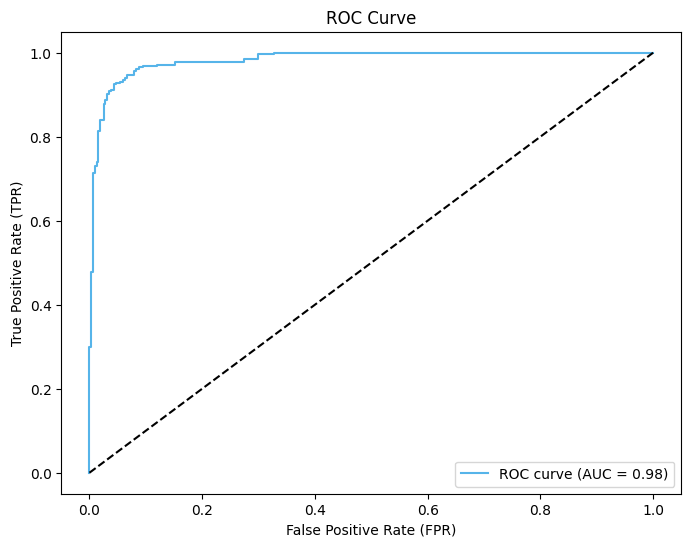

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    # Hyperparameter tuning
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    gru_units = trial.suggest_int('gru_units', 64, 256, step=32)  # Adjusted to start from 64
    dense_units = trial.suggest_int('dense_units', 16, 128, step=16)  # Adjusted to match previous range
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)  # Uniform range for dropout
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    rnn_activation = trial.suggest_categorical('rnn_activation', ['tanh', 'relu', 'swish'])  # Added activation hyperparameter

    # Step 1: Define the GRU model
    model = Sequential([
        Input(shape=X_train.shape[1:]),  # Input layer
        Masking(mask_value=0.0),  # Masking layer to handle padded sequences
        GRU(gru_units, activation=rnn_activation, return_sequences=False, dropout=dropout_rate),  # GRU layer with activation
        Dense(dense_units, activation='relu'),  # Dense hidden layer
        Dropout(dropout_rate),  # Dropout for regularization
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    # Step 2: Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Step 3: Train the model
    history = model.fit(
        X_train, y_train,
        epochs=10,  # Use fewer epochs for faster tuning
        batch_size=batch_size,
        validation_data=(X_val, y_val),  # Explicit validation set
        verbose=0
    )

    # Step 4: Evaluate the model
    y_pred_prob = model.predict(X_val).ravel()
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_val, y_pred_prob)

    # Log metrics to Optuna
    trial.set_user_attr("accuracy", accuracy)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("f1_score", f1)
    trial.set_user_attr("roc_auc", roc_auc)

    # Return a single metric for optimization (e.g., F1-score)
    return f1  # Optimize for F1 score

# Create the Optuna study
study = optuna.create_study(direction='maximize')  # Maximize F1 score
study.optimize(objective, n_trials=50)  # Run 50 trials

# Display the best hyperparameters and metrics
print("Best hyperparameters:")
print(study.best_params)

print("\nBest trial metrics:")
best_trial = study.best_trial
print(f"Accuracy: {best_trial.user_attrs['accuracy']:.4f}")
print(f"Precision: {best_trial.user_attrs['precision']:.4f}")
print(f"Recall: {best_trial.user_attrs['recall']:.4f}")
print(f"F1 Score: {best_trial.user_attrs['f1_score']:.4f}")
print(f"ROC-AUC: {best_trial.user_attrs['roc_auc']:.4f}")

# Re-train the model using the best hyperparameters
best_params = study.best_params
model = Sequential([
    Input(shape=X_train.shape[1:]),
    Masking(mask_value=0.0),
    GRU(best_params['gru_units'], activation=best_params['rnn_activation'], return_sequences=False, dropout=best_params['dropout_rate']),
    Dense(best_params['dense_units'], activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=best_params['batch_size'],
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=2
)

# Evaluate the final model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Final Test Loss: {loss:.4f}")
print(f"Final Test Accuracy: {accuracy:.4f}")

# Generate predictions and evaluate the results
y_pred_prob = model.predict(X_test).ravel()
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC: {roc_auc:.4f}")

y_pred = (y_pred_prob > 0.5).astype(int)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()



**Performance Metrics Test**

Test Loss: 0.1696
Test Accuracy: 93.87%
The model achieves a high accuracy of 93.87% on unseen data, indicating reliable predictions of employee suspension status.

**Classification Performance**

Precision: 95%
The model demonstrates strong reliability, with 95% of the predicted non-suspensions being correct.
Recall: 95%
The high recall reflects the model’s effectiveness in identifying nearly all true suspensions, minimizing false negatives.
F1-Score: 94%
The F1 Score highlights a balanced trade-off between precision and recall, showcasing the model's overall performance in classification tasks.

The ROC-AUC of 98.24% underscores the model’s robust ability to differentiate between the two classes, ensuring reliability in suspension predictions.
The low test loss (0.1696) and high accuracy (93.87%) highlight the model’s strong generalization to unseen data, making it a practical solution for real-world applications.

#Keras Tuner GRU

Trial 30 Complete [00h 00m 42s]
val_loss: 0.3340386748313904

Best val_loss So Far: 0.18417669832706451
Total elapsed time: 00h 23m 50s
Best Hyperparameters:
GRU Units: 160
Dropout Rate: 0.25
Dense Units: 32
Learning Rate: 0.0041383782670801
Epoch 1/50
93/93 - 3s - 37ms/step - accuracy: 0.7216 - loss: 0.5593 - val_accuracy: 0.7692 - val_loss: 0.4989
Epoch 2/50
93/93 - 1s - 14ms/step - accuracy: 0.7516 - loss: 0.5257 - val_accuracy: 0.8085 - val_loss: 0.4814
Epoch 3/50
93/93 - 1s - 13ms/step - accuracy: 0.7607 - loss: 0.5130 - val_accuracy: 0.8022 - val_loss: 0.4504
Epoch 4/50
93/93 - 1s - 13ms/step - accuracy: 0.7634 - loss: 0.4891 - val_accuracy: 0.8100 - val_loss: 0.4235
Epoch 5/50
93/93 - 1s - 14ms/step - accuracy: 0.7772 - loss: 0.4679 - val_accuracy: 0.8163 - val_loss: 0.4171
Epoch 6/50
93/93 - 1s - 14ms/step - accuracy: 0.7853 - loss: 0.4568 - val_accuracy: 0.8226 - val_loss: 0.4003
Epoch 7/50
93/93 - 1s - 14ms/step - accuracy: 0.8015 - loss: 0.4317 - val_accuracy: 0.8383 - val_l

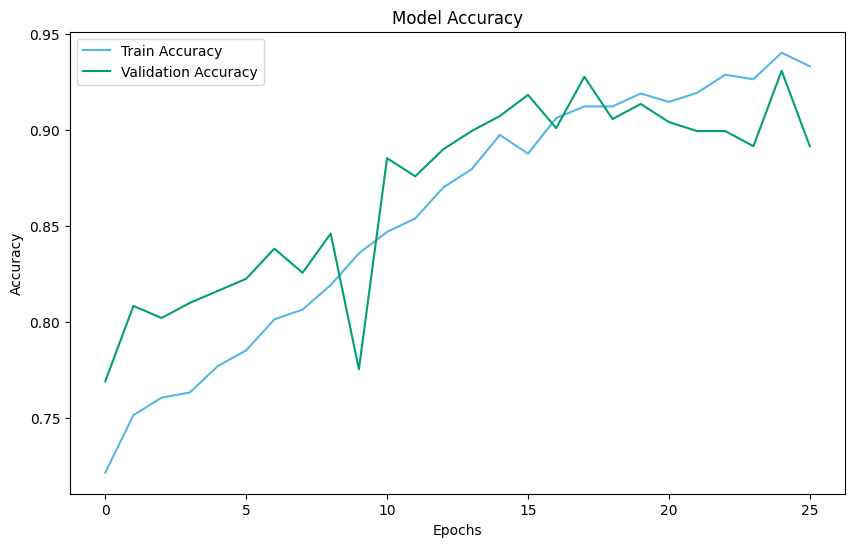

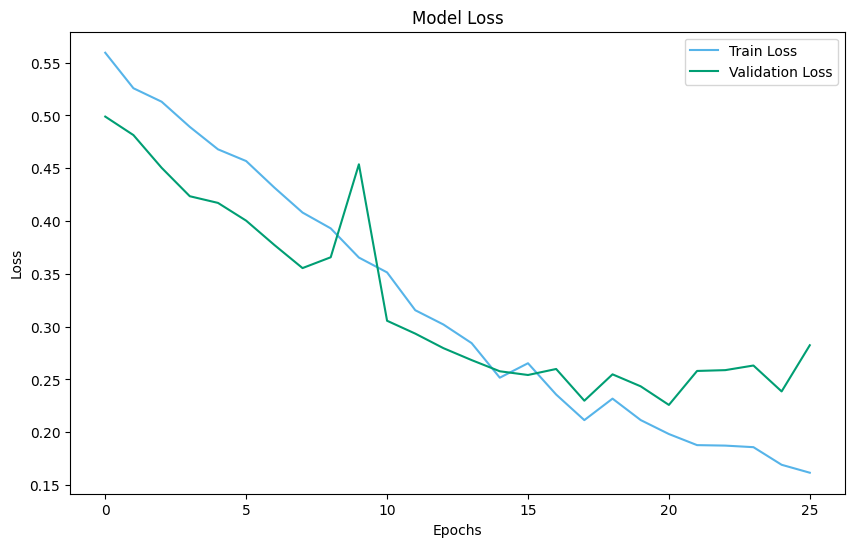

In [ ]:
# Define the model-building function with RNN hyperparameters applied to GRU
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=X_train.shape[1:]))
    model.add(Masking(mask_value=0.0))

    # GRU layer
    model.add(GRU(
        units=hp.Int('gru_units', min_value=96, max_value=160, step=32),  # RNN units range applied here
        activation='tanh',
        return_sequences=False,
        dropout=hp.Float('dropout_rate', min_value=0.2, max_value=0.4, step=0.05)  # Dropout rate range
    ))

    # Dense layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=64, step=16),  # Dense units range
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.4, step=0.05)))  # Dropout rate range

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-3, max_value=5e-3, sampling='log')),  # Learning rate
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',  # Optimize validation loss
    max_trials=30,  # Number of trials
    executions_per_trial=1,  # Executions per trial
    directory='gru_tuning_dir',  # Save tuning results
    project_name='gru_hyperparameter_tuning'
)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Run the hyperparameter search
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,  # Fixed batch size during search
    callbacks=[early_stopping],
    verbose=2
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"GRU Units: {best_hps.get('gru_units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model on the full training set
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

# Evaluate on test data
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Additional metrics
y_pred_prob = best_model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification metrics
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("\nFinal Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



**Performance Metrics**
Test Loss: 0.2232
Test Accuracy: 90.09%
The model achieves an accuracy of 90.09%, correctly predicting the majority of employee suspension statuses on unseen data.

**Classification Performance**
Precision: 85.12%
The model demonstrates strong reliability in identifying true positive predictions, with 85.12% of the predicted suspensions being correct.
Recall: 97.17%
The high recall indicates the model’s effectiveness in identifying nearly all actual suspensions, minimizing false negatives.
F1-Score: 90.75%
The F1 Score reflects a balanced trade-off between precision and recall, emphasizing the model's overall classification performance.
ROC-AUC: 98.32%
The exceptionally high AUC demonstrates the model’s excellent discriminative ability to distinguish between suspended and non-suspended employees.

The ROC-AUC of 98.32% indicates the model’s ability to accurately distinguish between the two classes, underscoring its reliability for predicting employee suspensions.

The low test loss (0.2232) and high accuracy (90.09%) demonstrate that the model generalizes well to unseen data, ensuring its applicability in real-world scenarios.